# Post-scVI analysis of donor P13 data: SN+multiome RNA-seq

After CCG removal and doublets removal (both by genotype and GEX)

This the version of the manifold after running scVI by `sample` and incorporating:

09.11.2021

What happens here:
- load preprocessed object (raw filtered counts)
- do normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- calculate neighborhood graph on the latent dimensionality reporesentation from scVI
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'

## Reading the preprocessed object

Preprocessing happened in S0 notebook

In [6]:
# reading the raw filtered object from joint analysis
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [7]:
# reading IDs of final cells to keep after doublet exclusion (scrublet and souporcell)
nodoublet_nulcei_IDs = pd.read_csv(save_path + 'obs_table_nodoublets.csv', index_col=0)
nodoublet_nulcei_IDs

n_genes donor  \
barcode_sample                                                      
AAACCCAAGATACATG-1_WSSS_PLA8764121                     1253   P13   
AAACCCACAAATCCCA-1_WSSS_PLA8764121                     1279   P13   
AAACCCACAACTGTGT-1_WSSS_PLA8764121                      473   P13   
AAACCCACAAGCTGCC-1_WSSS_PLA8764121                     1360   P13   
AAACCCACATAACCCA-1_WSSS_PLA8764121                     1891   P13   
...                                                     ...   ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920_and_40110_P...     2409   P13   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920_and_40110_P...     4129   P13   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920_and_40110_P...     3116   P13   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920_and_40110_P...     3696   P13   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920_and_40110_P...     2130   P13   

                                                   tissue_block      age  \
barcode_sample                                                             
AAACCCAAGATACATG-1_WSSS_PLA8764121                     PU8-9_B5  8-9_PCW   
AAACCCACAAATCCCA-1_WSSS_PLA8764121                     PU8-9_B5  8-9_PCW   
AAACCCACAACTGTGT-1_WSSS_PLA8764121                     PU8-9_B5  8-9_PCW   
AAACCCACAAGCTGCC-1_WSSS_PLA8764121                     PU8-9_B5  8-9_PCW   
AAACCCACATAACCCA-1_WSSS_PLA8764121                     PU8-9_B5  8-9_PCW   
...                                                         ...      ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920_and_40110_P...      unknown  8-9_PCW   

                                                                                         sample  \
barcode_sample                                                                                    
AAACCCAAGATACATG-1_WSSS_PLA8764121                                              WSSS_PLA8764121   
AAACCCACAAATCCCA-1_WSSS_PLA8764121                                              WSSS_PLA8764121   
AAACCCACAACTGTGT-1_WSSS_PLA8764121                                              WSSS_PLA8764121   
AAACCCACAAGCTGCC-1_WSSS_PLA8764121                                              WSSS_PLA8764121   
AAACCCACATAACCCA-1_WSSS_PLA8764121                                              WSSS_PLA8764121   
...                                                                                         ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920_and_40110_P...  Pla_Camb10714920_and_40110_Pla_Camb10687916   

                                                    percent_mito  n_counts  \
barcode_sample                                                               
AAACCCAAGATACATG-1_WSSS_PLA8764121                      0.000000    1820.0   
AAACCCACAAATCCCA-1_WSSS_PLA8764121                      0.000535    1868.0   
AAACCCACAACTGTGT-1_WSSS_PLA8764121                      0.000000     556.0   
AAACCCACAAGCTGCC-1_WSSS_PLA8764121                      0.000473    2116.0   
AAACCCACATAACCCA-1_WSSS_PLA8764121                      0.000305    3274.0   
...                                                          ...       ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920_and_40110_P...      0.007270    5227.0   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920_and_40110_P...      0.002532   17379.0   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920_and_40110_P...      0.004499    7779.0   
TTTGTTGGTTTACTTG-1_

In [8]:
# subsetting the adata object to final cells
adata = adata[list(nodoublet_nulcei_IDs.index), :].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'

In [9]:
np.unique(adata.obs['sample'])

array(['Pla_Camb10691970', 'Pla_Camb10691971',
       'Pla_Camb10714919_and_40110_Pla_Camb10687915',
       'Pla_Camb10714920_and_40110_Pla_Camb10687916', 'WSSS_PLA8764121',
       'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751'],
      dtype=object)

In [10]:
# adding metadata
for col in nodoublet_nulcei_IDs.columns:
    print(col)
    adata.obs[col] = nodoublet_nulcei_IDs.loc[adata.obs_names,col]

n_genes
donor
tissue_block
age
sample
percent_mito
n_counts
dataset
technique
scrublet_score
scrublet_cluster_score
bh_pval
batch
is_doublet
barcode_sample_copy
barcode
souporcell_assignment
inter_ind_doublet
S_score
G2M_score
phase
annotation_prev
louvain
is_doublet_propagate
origin_M_F


In [11]:
np.unique(adata.obs['sample'])

array(['Pla_Camb10691970', 'Pla_Camb10691971',
       'Pla_Camb10714919_and_40110_Pla_Camb10687915',
       'Pla_Camb10714920_and_40110_Pla_Camb10687916', 'WSSS_PLA8764121',
       'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751'],
      dtype=object)

In [12]:
adata.obs['annotation_prev_or_removed'] = adata.obs['annotation_prev']

adata.obs['annotation_prev_or_removed'] = ['removed' if (value == '0_none' and sample in ['WSSS_PLA8764121',
       'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751']) else value for value,sample in zip(adata.obs['annotation_prev'], adata.obs['sample'])]

In [13]:
np.unique(adata.obs['annotation_prev_or_removed'])

array(['0_none', 'DC1', 'EVT_1', 'EVT_2', 'EVT_3', 'Endo_F', 'Endo_L',
       'Endo_M', 'GC', 'HOFB', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing',
       'VCT_p', 'dEpi_secretory', 'dM2', 'dNK1', 'dNK3', 'dPV1', 'dS1',
       'dS3', 'eEVT', 'fF', 'fPV', 'iEVT', 'removed', 'uSMC'],
      dtype=object)

In [14]:
# quick check to see if raw is raw or not
expr_mtx_dense = adata[adata.obs['sample'] == 'Pla_Camb10691970'].X.todense()

In [15]:
# YAS we all good
np.unique(expr_mtx_dense)

matrix([[   0.,    0.,    0., ..., 4162., 4637., 6366.]], dtype=float32)

________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [16]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


_____________________________________________________________________________________________________________________________________________________________

In [17]:
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    587 total control genes are used. (0:00:03)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    544 total control genes are used. (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


In [18]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p'

_______________________________________________________________________________________________________

# Read in scVI-calculated latent representation

In [19]:
# a few values
n_latent = [5, 10, 15, 17,
            20, 30, 40
           ]

### 09.11.2021 run, correction by `sample`

In [20]:
latent_representations_donor = {}

# didn't align as well as corrected by donor_sample

for n_latent_value in n_latent:
    print(n_latent_value)
    
    curr_path = '/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/20211109_obsm_with_scVI_latent_representation_n_' + str(n_latent_value) + '_after_CCG_removal_and_all_doublet_exclusion_by_sample_donor_P13_all_SN_and_multiome.csv' 
        
    latent_representations_donor[n_latent_value] = pd.read_csv(curr_path, index_col=0)

5
10
15
17
20
30
40


In [21]:
# assign these latent_representations into adata.obsm
for n_latent_value in n_latent:
    print(n_latent_value)
    adata.obsm['X_scVI_n_latent_' + str(n_latent_value) + '_sample'] = np.array(latent_representations_donor[n_latent_value])

5
10
15
17
20
30
40


In [22]:
adata.obsm['X_scVI_n_latent_5_sample'].shape

(74244, 5)

__________________________________________________________________________________________________________________________________________________________________

### Neighbourhood graph & UMAP

In [23]:
%%time

for n_latent_value in n_latent:
    print(n_latent_value)
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_scVI_n_latent_' + str(n_latent_value) + '_sample',
               key_added='neighbors_scVI_n_latent_' + str(n_latent_value) + '_sample' )

computing neighbors


5


    finished: added to `.uns['neighbors_scVI_n_latent_5_sample']`
    `.obsp['neighbors_scVI_n_latent_5_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_5_sample_connectivities']`, weighted adjacency matrix (0:00:20)
computing neighbors


10


    finished: added to `.uns['neighbors_scVI_n_latent_10_sample']`
    `.obsp['neighbors_scVI_n_latent_10_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_10_sample_connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors


15


    finished: added to `.uns['neighbors_scVI_n_latent_15_sample']`
    `.obsp['neighbors_scVI_n_latent_15_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_15_sample_connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors


17


    finished: added to `.uns['neighbors_scVI_n_latent_17_sample']`
    `.obsp['neighbors_scVI_n_latent_17_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_17_sample_connectivities']`, weighted adjacency matrix (0:00:06)
computing neighbors


20


    finished: added to `.uns['neighbors_scVI_n_latent_20_sample']`
    `.obsp['neighbors_scVI_n_latent_20_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_20_sample_connectivities']`, weighted adjacency matrix (0:00:07)
computing neighbors


30


    finished: added to `.uns['neighbors_scVI_n_latent_30_sample']`
    `.obsp['neighbors_scVI_n_latent_30_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_30_sample_connectivities']`, weighted adjacency matrix (0:00:07)
computing neighbors


40


    finished: added to `.uns['neighbors_scVI_n_latent_40_sample']`
    `.obsp['neighbors_scVI_n_latent_40_sample_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_40_sample_connectivities']`, weighted adjacency matrix (0:00:07)


CPU times: user 1min 52s, sys: 2min 52s, total: 4min 44s
Wall time: 1min 1s


In [24]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p', 'neighbors_scVI_n_latent_5_sample', 'neighbors_scVI_n_lat

__________________________________________________________________________________________________________________________________________________________________

In [25]:
%%time

for n_latent_value in n_latent:
    print(n_latent_value)

    sc.tl.umap(adata, random_state=0,
              neighbors_key='neighbors_scVI_n_latent_' + str(n_latent_value) + '_sample')
    # copy current adata.obsm['X_umap'] into adata.obsm['X_umap_scVI_n_latent_' + str(n_latent_value)]
    adata.obsm['X_umap_scVI_n_latent_' + str(n_latent_value) + '_sample'] = adata.obsm['X_umap']
    
    

computing UMAP


5


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)
computing UMAP


10


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)
computing UMAP


15


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
computing UMAP


17


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)
computing UMAP


20


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
computing UMAP


30


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)
computing UMAP


40


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


CPU times: user 12min 29s, sys: 6min 45s, total: 19min 15s
Wall time: 4min 33s


In [26]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['Pla_Camb10691970', 'Pla_Camb10691971',
        'Pla_Camb10714919_and_40110_Pla_Camb10687915',
        'Pla_Camb10714920_and_40110_Pla_Camb10687916', 'WSSS_PLA8764121',
        'WSSS_PLA8764122', 'WSSS_PLA8810750', 'WSSS_PLA8810751'],
       dtype=object),
 array([ 9740,  9840,  5172,  5407,  8658,  8411, 14455, 12561]))

In [27]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p', 'neighbors_scVI_n_latent_5_sample', 'neighbors_scVI_n_lat

## Saving this object with all the manifolds calculated

In [28]:
adata.write(save_path + 'adata_P13_scVI_analysed_corr_by_sample_SN_and_multiome.h5ad')


... storing 'donor' as categorical
... storing 'tissue_block' as categorical
... storing 'age' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'technique' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'phase' as categorical
... storing 'annotation_prev' as categorical
... storing 'origin_M_F' as categorical
... storing 'annotation_prev_or_removed' as categorical


In [5]:
# reading the previously saved file
adata = sc.read(save_path + 'adata_P13_scVI_analysed_corr_by_sample_SN_and_multiome.h5ad')


In [16]:
palette_new = ['lightgrey', # none / new samples data
               '#d5e7f7',
                 '#d895ea',
                 '#9f6bac',
                 '#bf4cea',
                 '#b9a96b',
                 '#f8f4a8',
                 '#eacf68',
                 '#DBC7DE',
                 '#69b4ce',
                 '#eb5376',
                 '#ecdbe5',
                 '#e7a3c8',
                 '#b53279',
                 '#e96db3',
                 '#c35338',
                 '#66cef6',
                 '#deeab1',
                 '#2d563c',
                 '#6b6a6b',
                 '#c9bdb2',
                 '#eaa944',
                 '#FF1200',
                 '#a79388',
                 '#aeb1b7',
                 '#510058',
               'blue', # previously removed as soupy nuclei
                 '#f37a73']


### scVI-corrected by `sample`

n_latent = 5

### scVI-corrected by `sample`

n_latent = 10

### scVI-corrected by `sample`

n_latent = 15

### scVI-corrected by `sample`

n_latent = 20

### scVI-corrected by `sample`

n_latent = 17 - corresponds to optimal number of PCs for this object

In [6]:
curr_embedding_key = 'X_umap_scVI_n_latent_17_sample'

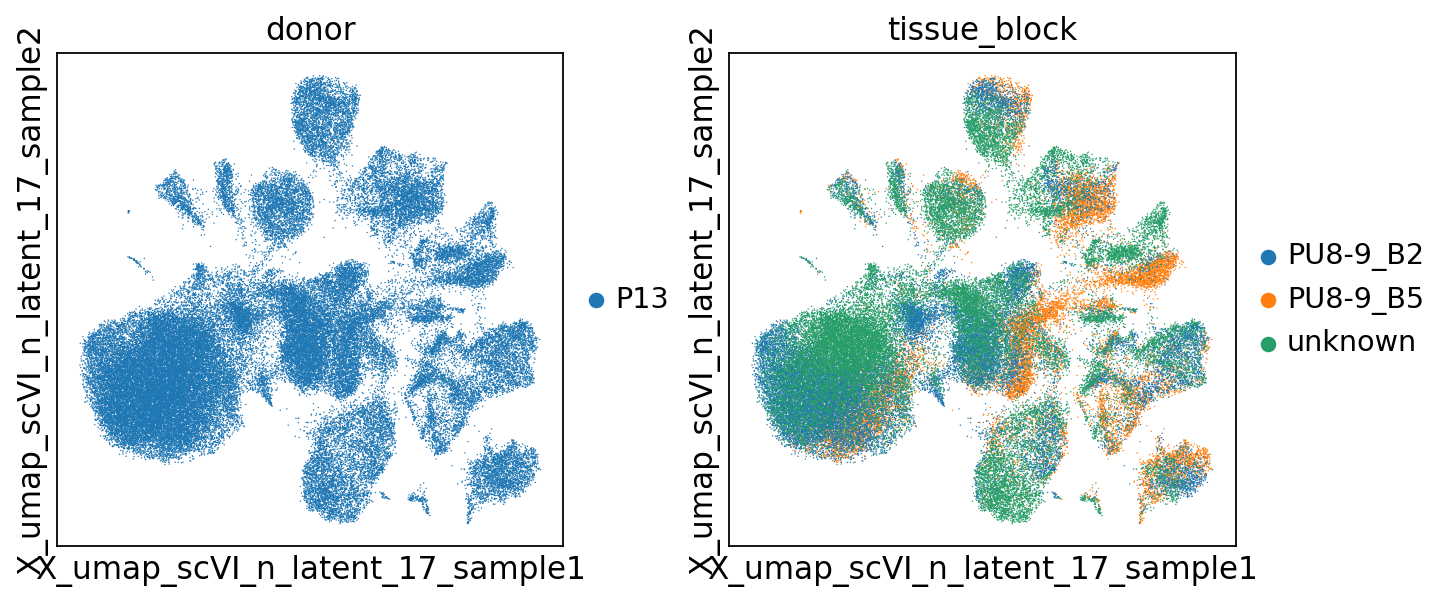

In [7]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['donor','tissue_block'])

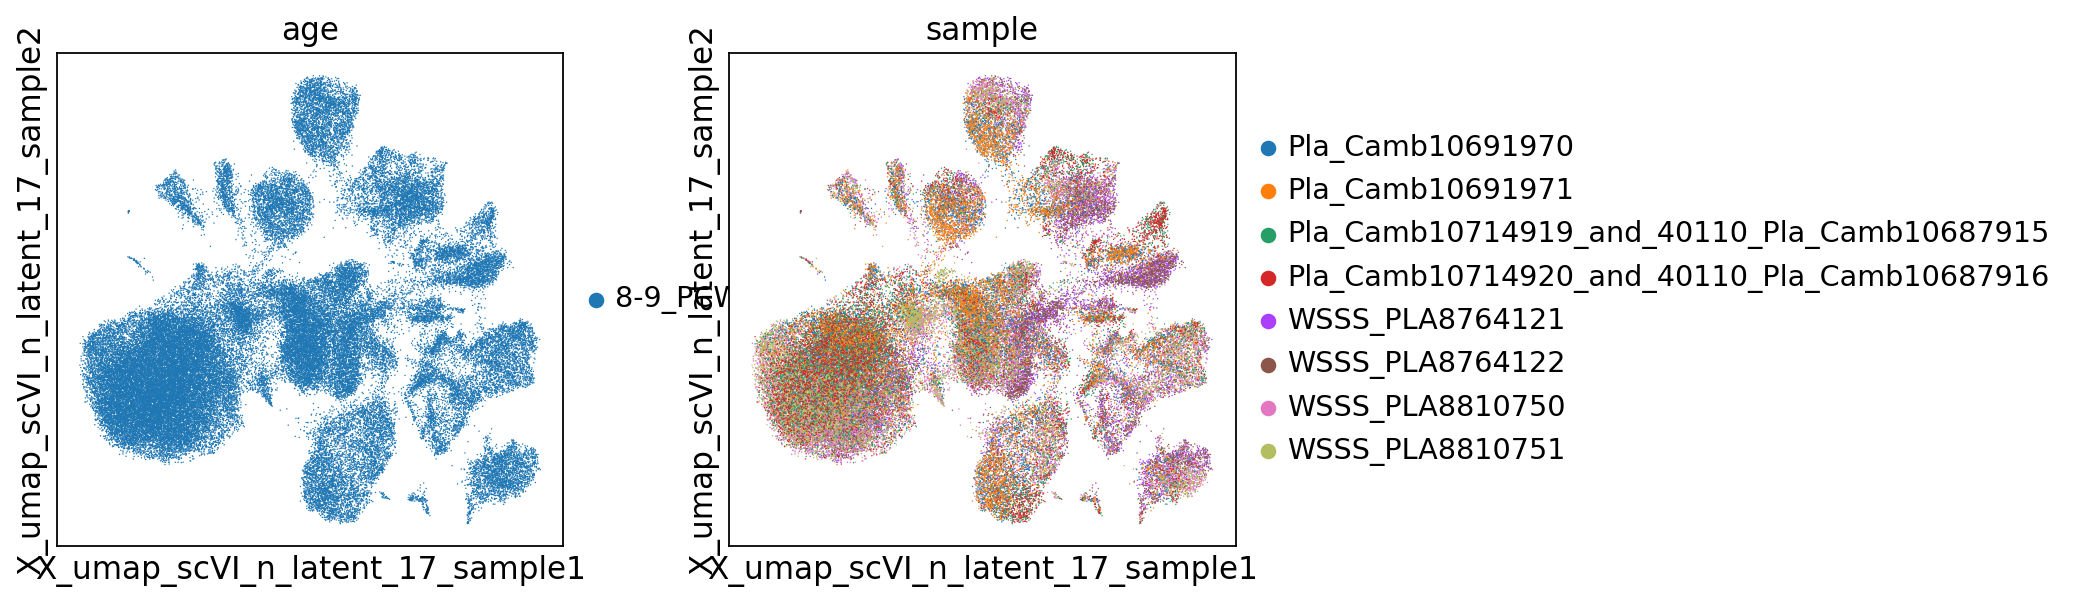

In [8]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['age','sample'])

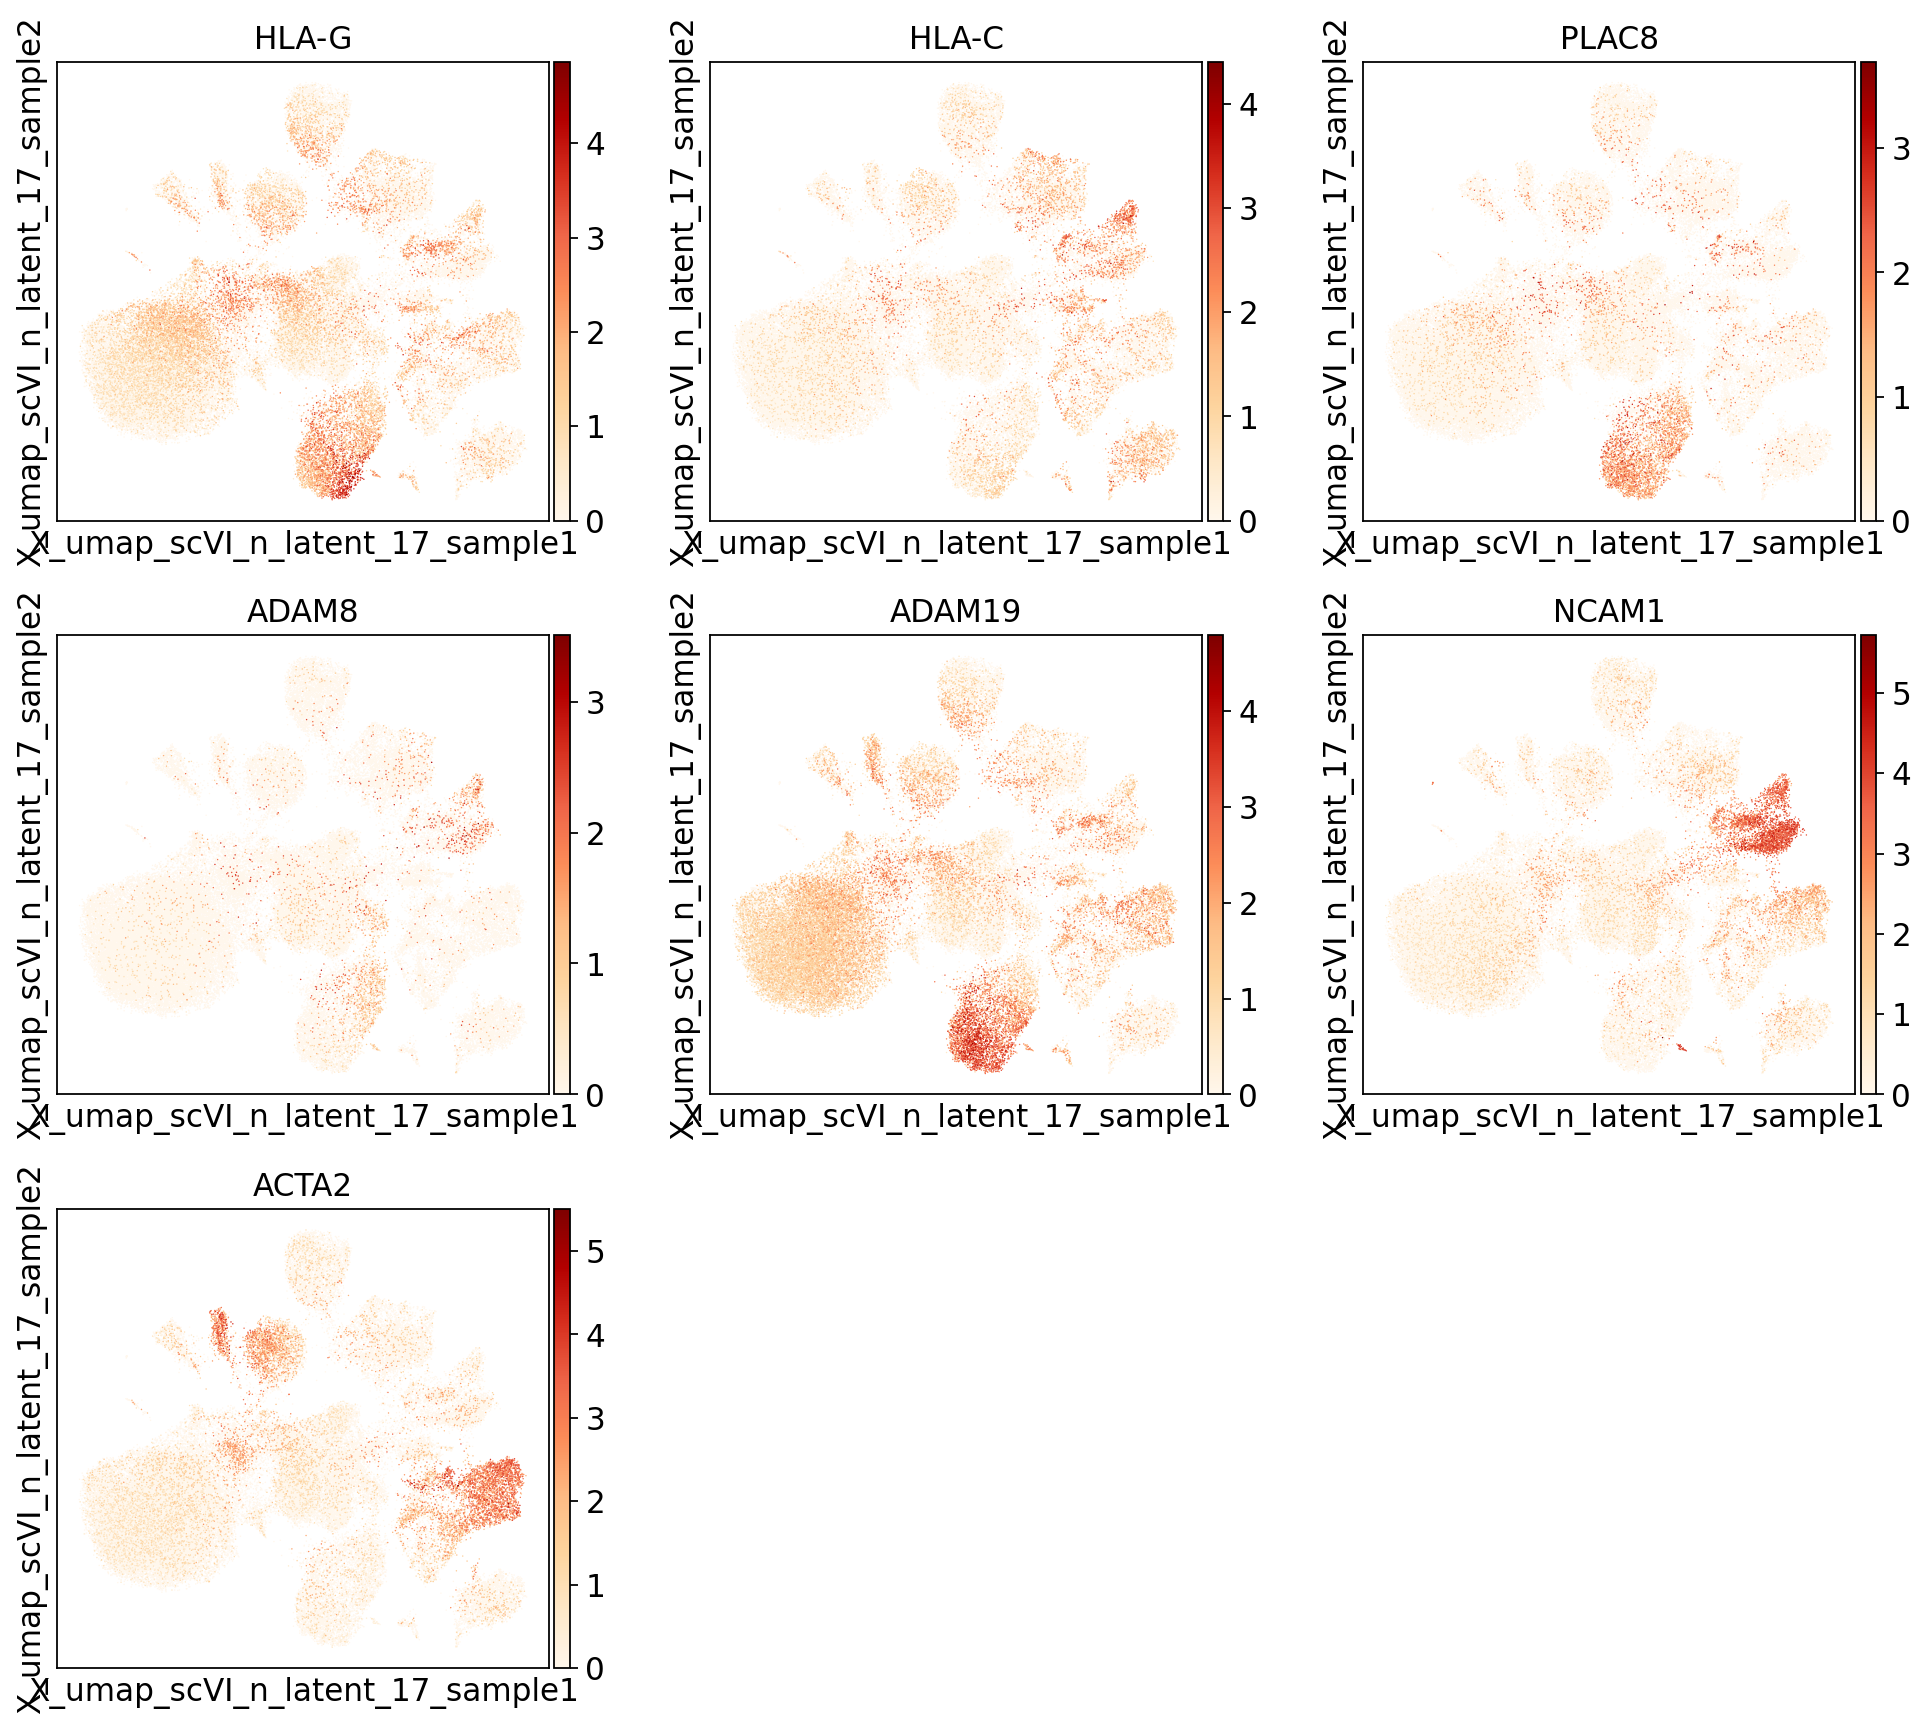

In [9]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['HLA-G','HLA-C','PLAC8',
                             'ADAM8','ADAM19',
                            'NCAM1','ACTA2'], ncols=3, use_raw=True, cmap='OrRd')

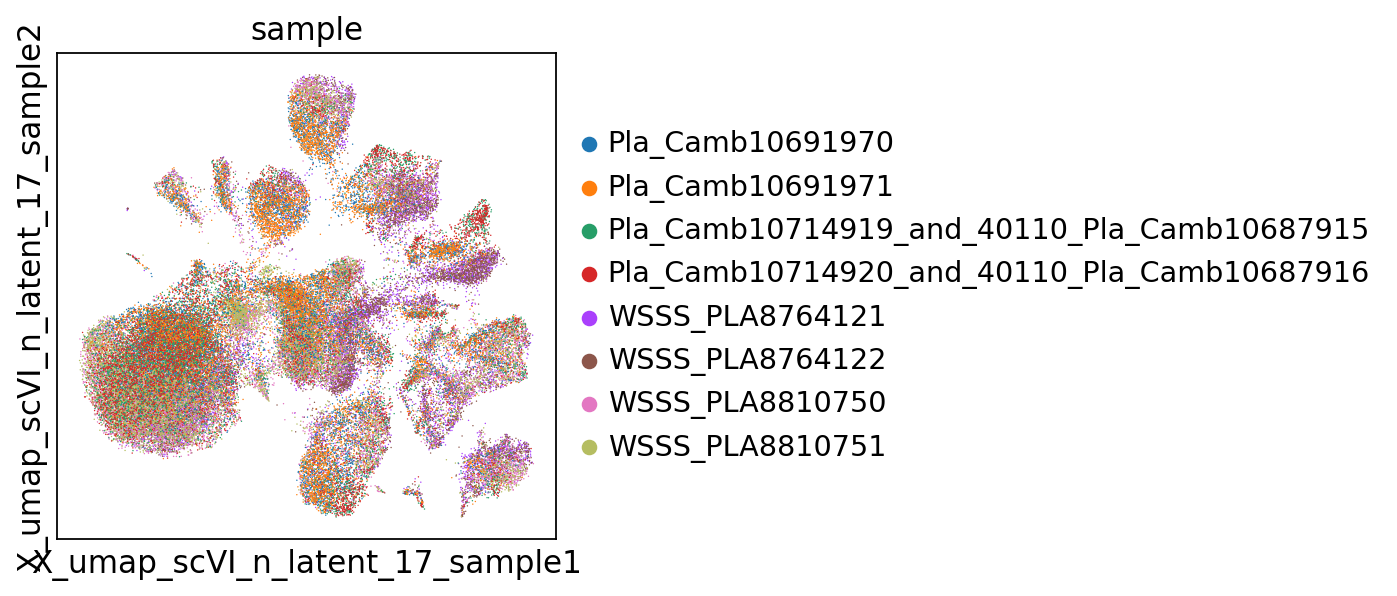

In [10]:
sc.pl.embedding(adata, curr_embedding_key, color=['sample'])

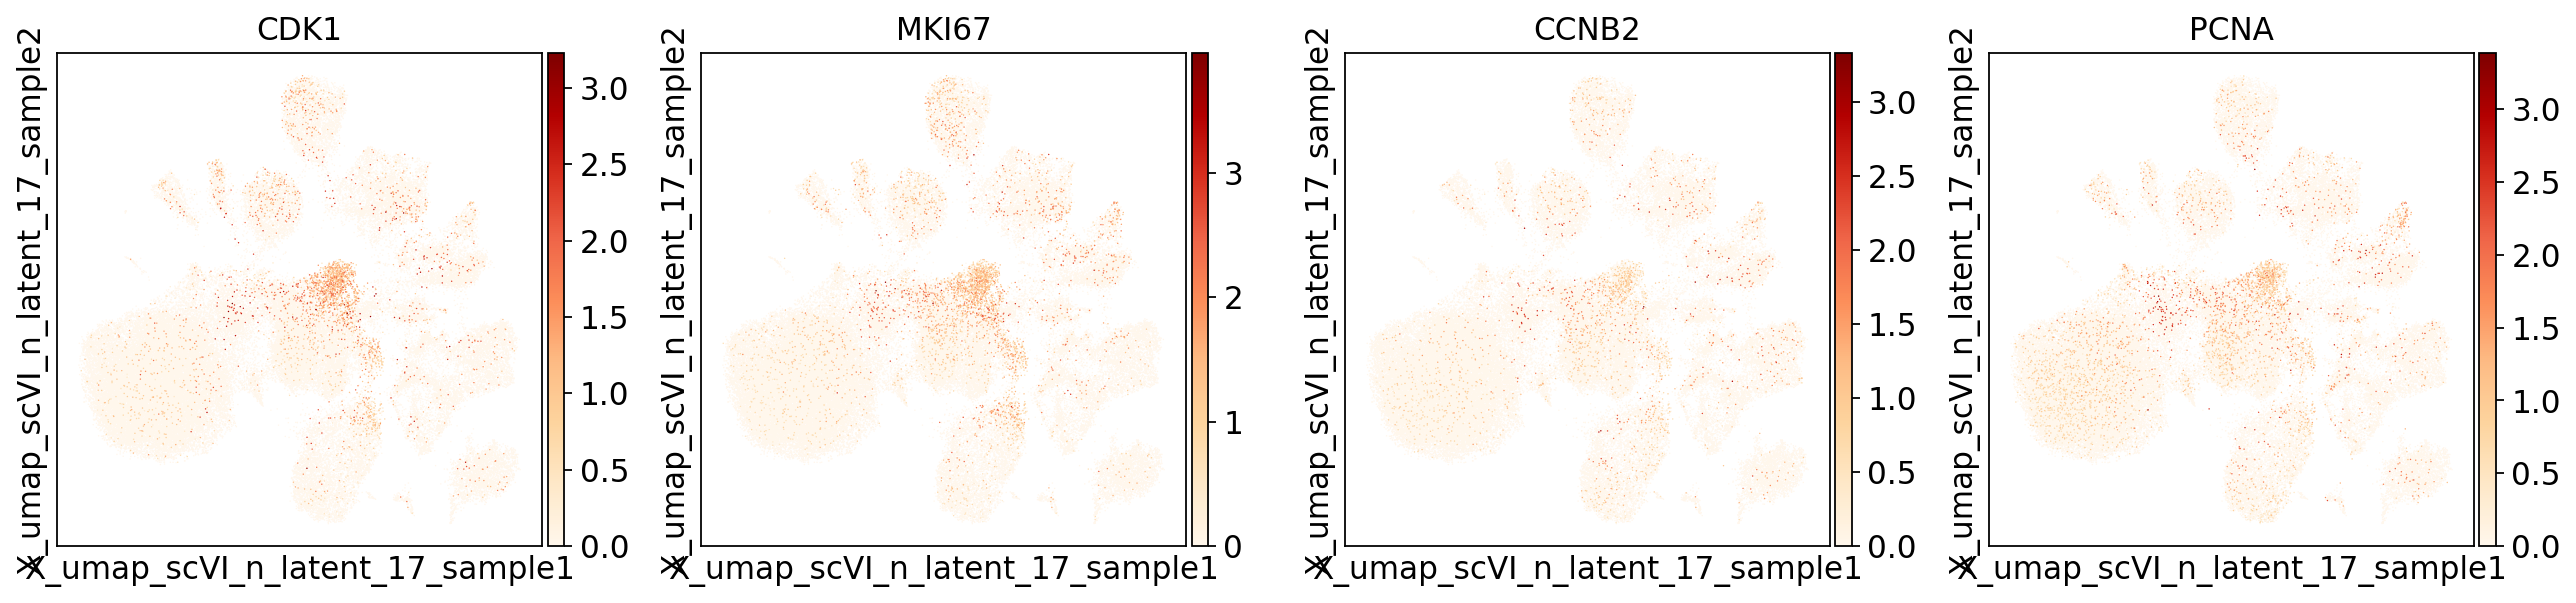

In [11]:
sc.pl.embedding(adata, curr_embedding_key, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

In [12]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'neighbors_scVI_n_latent_10_sample', 'neighbors_scVI_n_latent_15_s

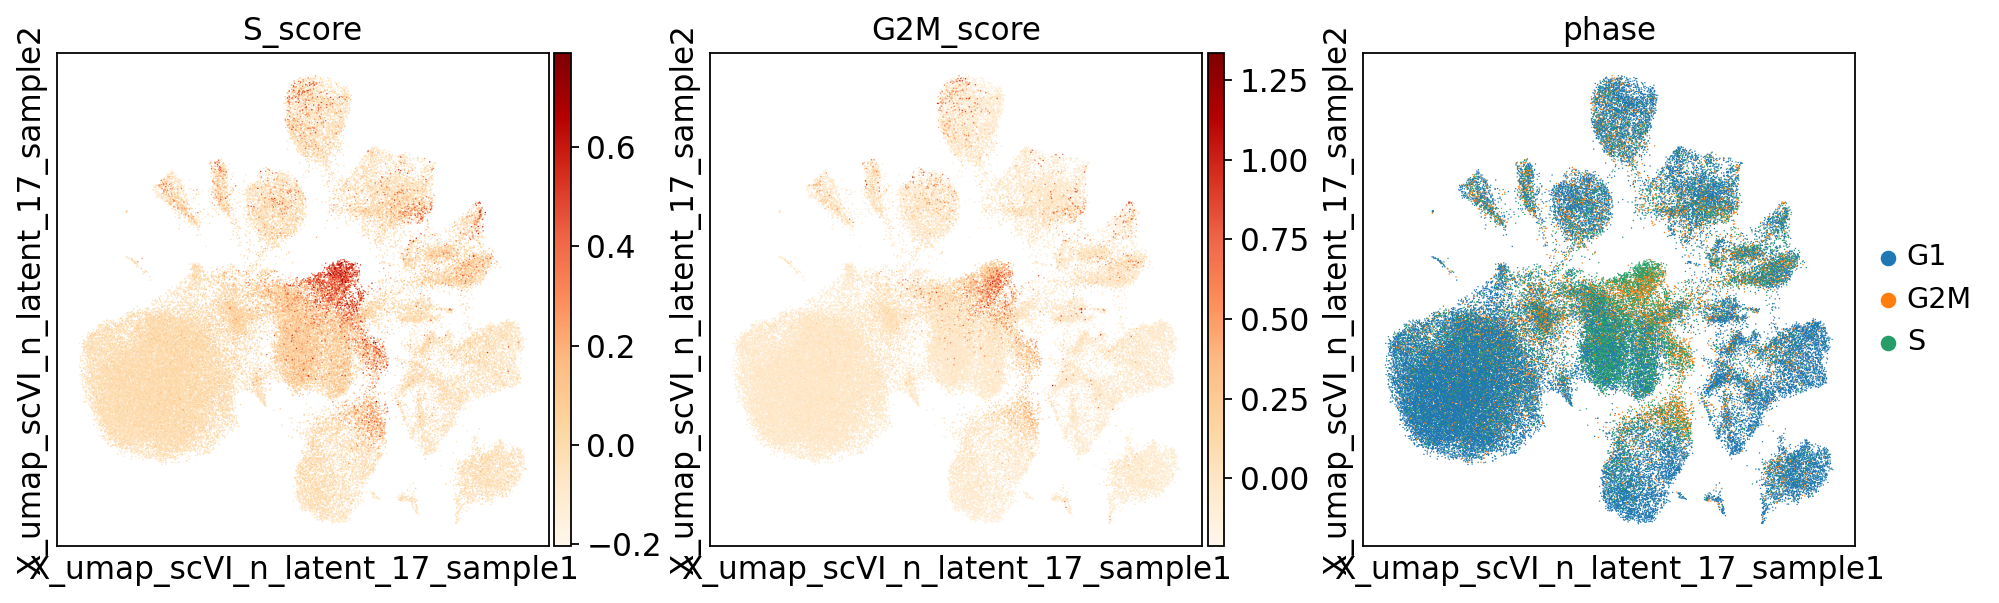

In [13]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['S_score','G2M_score','phase'], cmap='OrRd')

In [14]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'neighbors_scVI_n_latent_10_sample', 'neighbors_scVI_n_latent_15_s

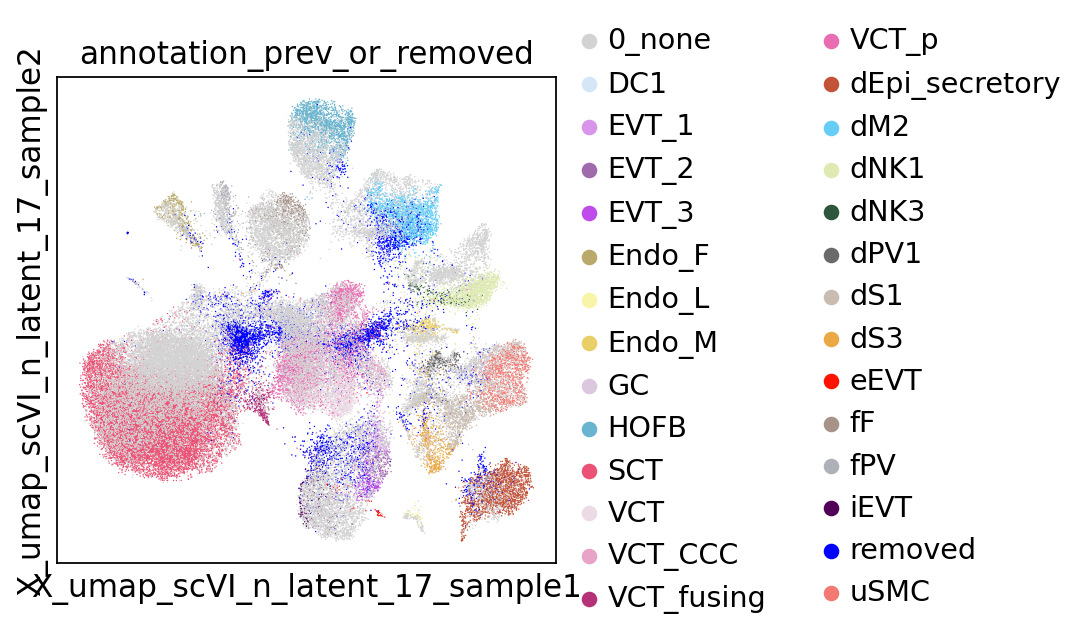

In [17]:
sc.pl.embedding(adata, curr_embedding_key, color=['annotation_prev_or_removed'], palette=palette_new)

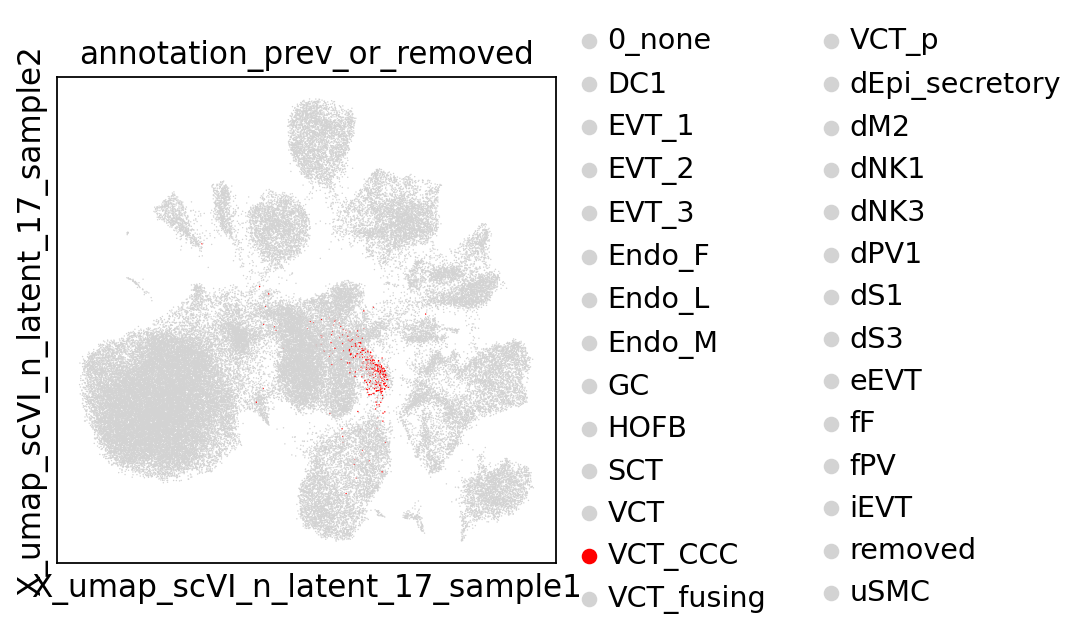

In [18]:
# where are VCT_CCC?
sc.pl.embedding(adata, curr_embedding_key, color=['annotation_prev_or_removed'], palette=['lightgrey']*12 + ['red'] + ['lightgrey']*14)

In [19]:
adata

AnnData object with n_obs × n_vars = 74244 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'neighbors_scVI_n_latent_10_sample', 'neighbors_scVI_n_latent_15_s

In [20]:
# cluster apart invading troph from VCT_CCC onwards
sc.tl.louvain(adata, resolution=1.0,
             neighbors_key = 'neighbors_scVI_n_latent_17_sample',
             key_added = 'louvain_scvi_n_latent_17')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain_scvi_n_latent_17', the cluster labels (adata.obs, categorical) (0:00:18)


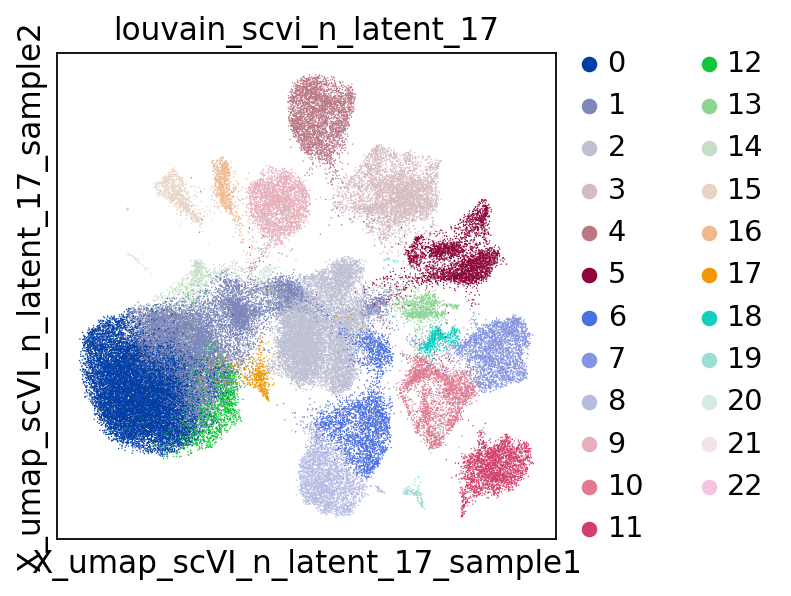

In [21]:
sc.pl.embedding(adata, curr_embedding_key, color='louvain_scvi_n_latent_17')

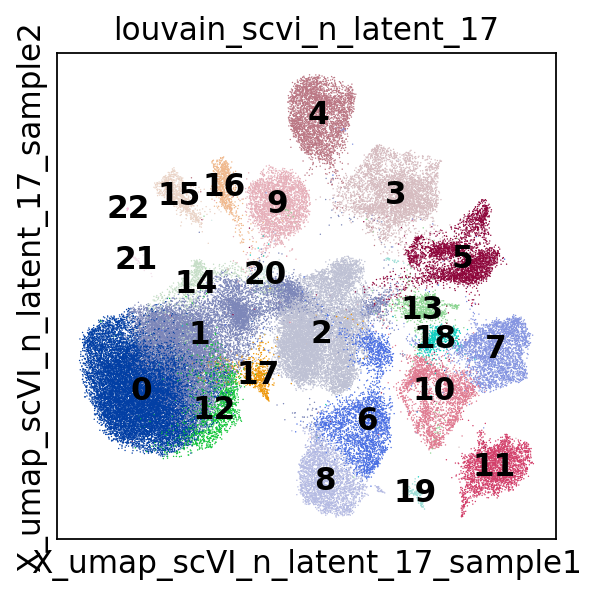

In [22]:
sc.pl.embedding(adata, curr_embedding_key, color='louvain_scvi_n_latent_17', legend_loc='on data')

# clusters 0,1,2,6,8,12,14,17 and 20 are trophoblast --> going to calculate CC-assoc genes and optimal n_PCs (see code below) and run scVI

In [23]:
# add 'trophoblast' or 'rest' labels
adata.obs['trophoblast_or_rest'] = ['trophoblast' if clus in ['0','1','2',
                                                              '6','8','12',
                                                              '14','17','20'] else 'rest' for clus in adata.obs['louvain_scvi_n_latent_17']]

In [24]:
# save these labels 
adata.obs.to_csv(save_path + 'obs_table_adata_scvi_SN_and_multiome_with_trophoblast_labels.csv')

### Preparation for scVI: 

1) Calculating cell cycle-associated genes (to later be excluded in scVI analysis)
2) Calculating a minimum extimate of number of latent variables to use in scVI analysis later (when doing batch correction) as the number of PCs optimally explaining this data

for a suset of data corresponding to only trophoblast (according to selection done above)

Let's see if cell cycle has an effect in trophoblast and remember them to exclude in scVI calculation

In [5]:
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

obs_table_with_louvain = pd.read_csv(save_path + 'obs_table_adata_scvi_SN_and_multiome_with_trophoblast_labels.csv', index_col=0)

adata.obs['trophoblast_or_rest'] = obs_table_with_louvain.loc[list(set(adata.obs_names) & set(obs_table_with_louvain.index)), 'trophoblast_or_rest']
adata = adata[adata.obs['trophoblast_or_rest'] == 'trophoblast'].copy()

adata_copy = adata.copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata_copy

AnnData object with n_obs × n_vars = 49361 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'trophoblast_or_rest'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'

In [7]:
# normalise and log transform
sc.pp.normalize_per_cell(adata_copy, counts_per_cell_after=1e4)
sc.pp.log1p(adata_copy)

# saving the raw attribute
adata_copy.raw = adata_copy.copy()

adata_copy.var_names_make_unique()
adata_copy.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Filter Cell cycle genes

### SN + multiome, all trophoblast states manifold

Per genes analysis: identify genes behaving like known cell cycle genes


In [8]:
cellcycle_adata = adata_copy.copy()
# Extract highly variable genes
#filter_result = sc.pp.filter_genes_dispersion(
#    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [9]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
#cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


In [10]:
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:01:34)


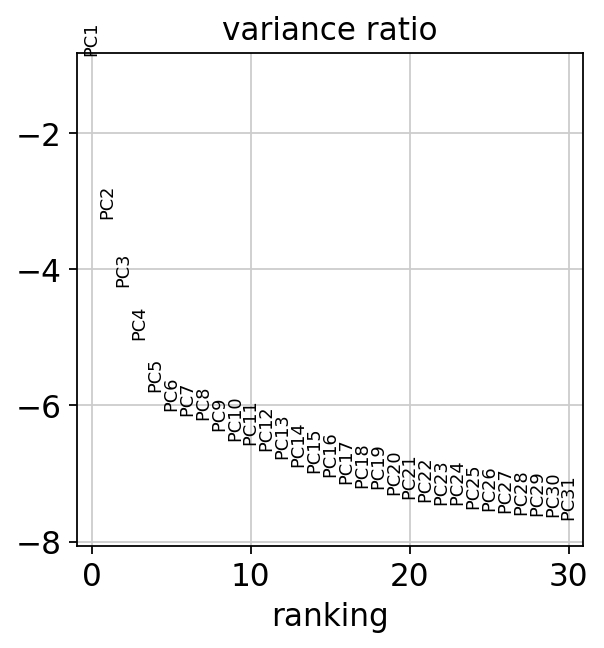

In [11]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
... storing 'trophoblast_or_rest' as categorical


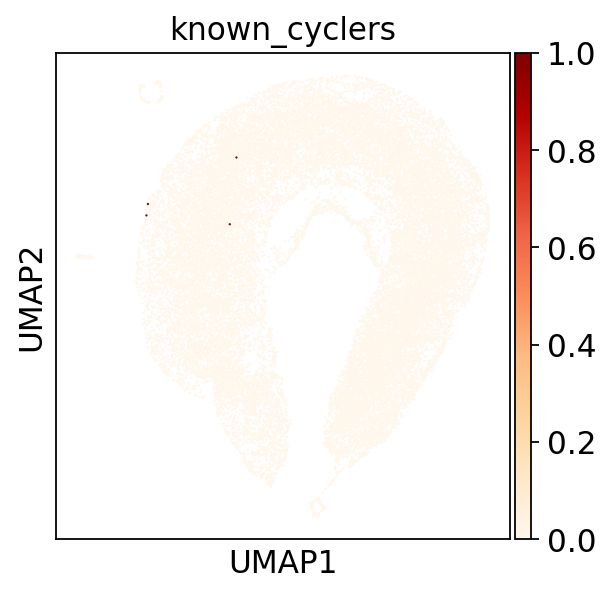

In [12]:
# Identify genes behaving like cc genes
num_pcs = 6
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [1 if gene in ['CDK1','MKI67','CCNB2','PCNA'] else 0 for gene in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


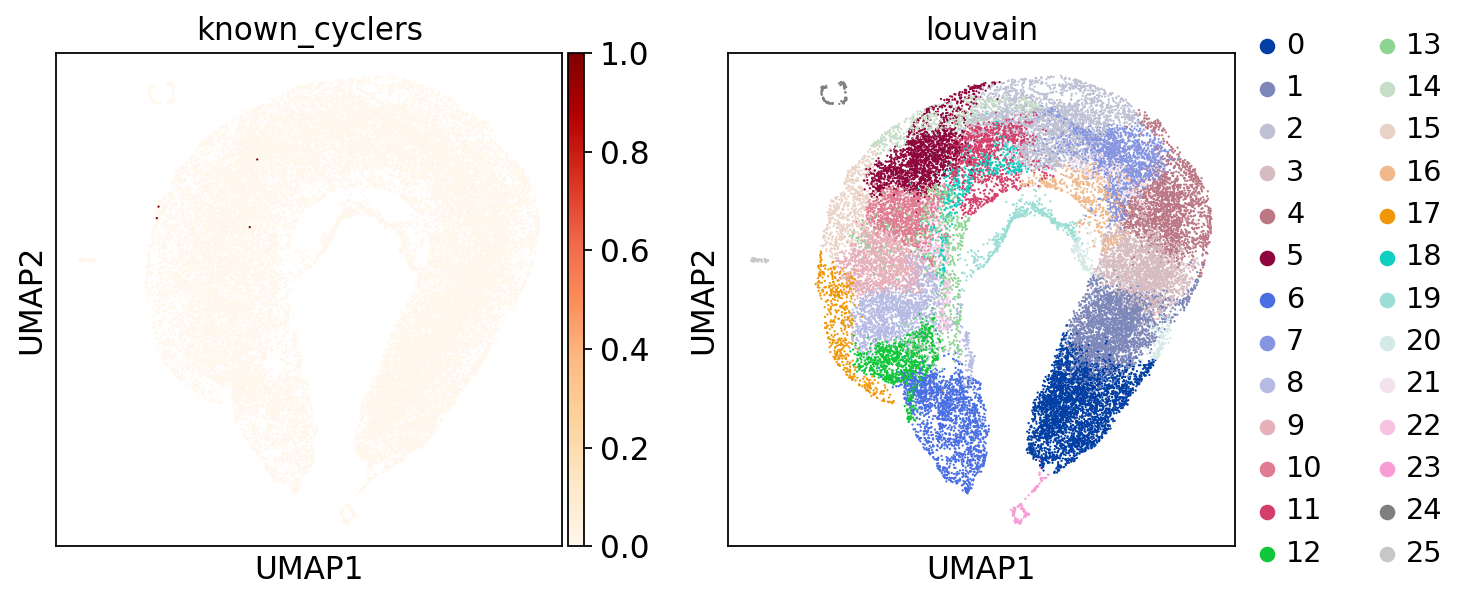

In [13]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [14]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67','CCNB2','PCNA'],'louvain'])


CDK1     15
MKI67    15
CCNB2     5
PCNA     10
Name: louvain, dtype: category
Categories (26, object): ['0', '1', '2', '3', ..., '22', '23', '24', '25']


In [15]:
adata_copy

AnnData object with n_obs × n_vars = 49361 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'trophoblast_or_rest'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p'

So removing genes from cluster 15 by filtering the main matrix

In [16]:
# Add unstructured dict-like annotation for ccgs
adata_copy.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='15')].index)
# Remove cc genes
adata_copy = adata_copy[:,[i not in adata_copy.uns['ccgs'] for i in adata_copy.var_names]]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata_copy

View of AnnData object with n_obs × n_vars = 49361 × 28458
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'trophoblast_or_rest'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p', 'ccgs'

In [18]:
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata_copy.var_names]
g2m_genes = [x for x in g2m_genes if x in adata_copy.var_names]
sc.tl.score_genes_cell_cycle(adata_copy, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
Trying to set attribute `.obs` of view, copying.
    finished: added
    'S_score', score of gene set (adata.obs).
    317 total control genes are used. (0:00:05)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    346 total control genes are used. (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


In [19]:
adata_copy

AnnData object with n_obs × n_vars = 49361 × 28458
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'trophoblast_or_rest', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p', 'ccgs'

In [20]:
# save for scVI
adata_copy.var.to_csv(save_path + 'genes_without_CC_assoc_genes_for_scVI_SN_and_multiome_trophoblast_20211110.csv')

# to recalc scVI with informed n_latent, let's see how many PCs explain the trophoblast subset of data


extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


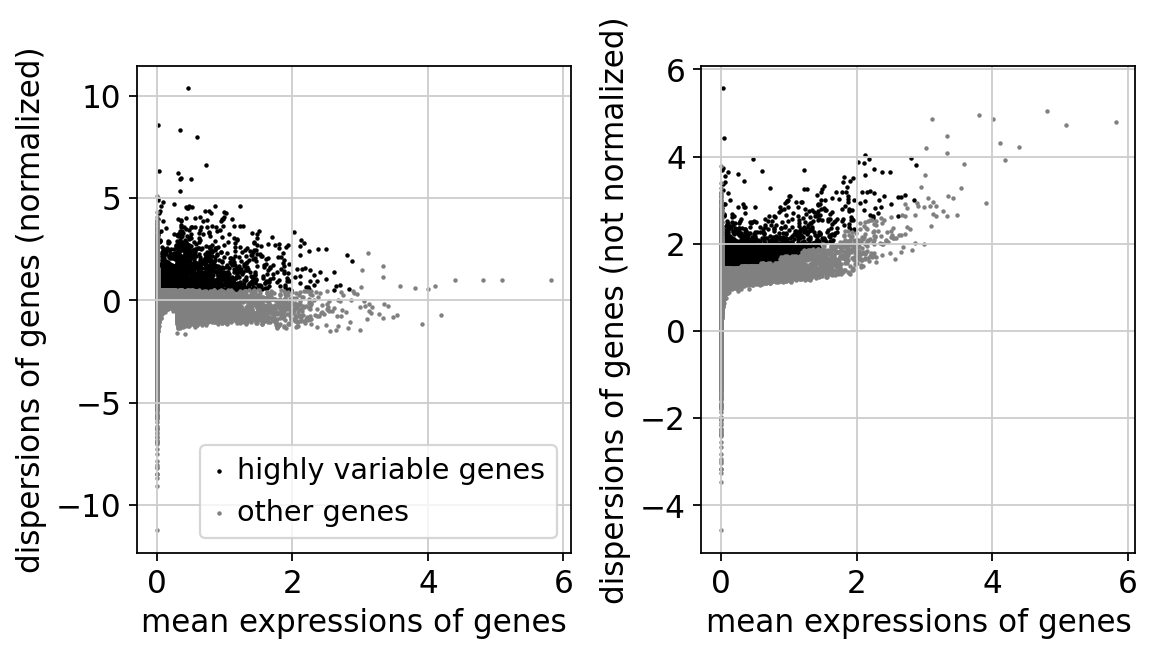

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


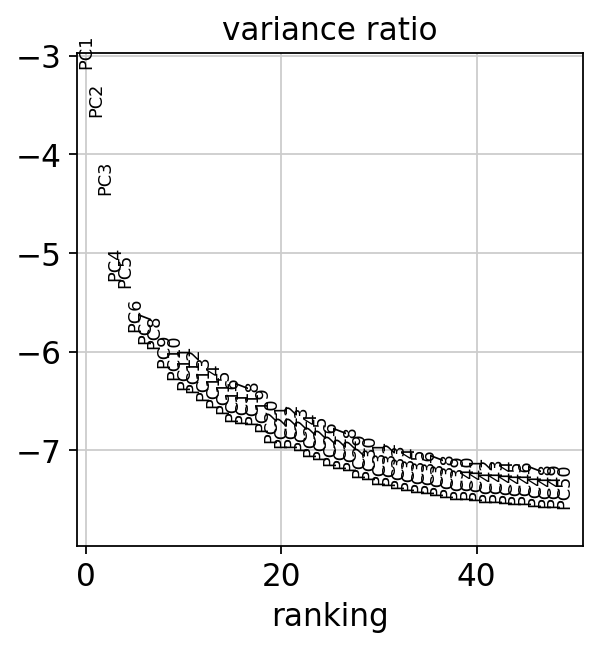

In [21]:
sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata_copy)

adata_copy_hvg = adata_copy[:, adata_copy.var['highly_variable']]

sc.pp.scale(adata_copy_hvg, max_value=10)

sc.tl.pca(adata_copy_hvg, svd_solver='arpack',
         n_comps=50)

sc.pl.pca_variance_ratio(adata_copy_hvg, log=True, save=False,
                        n_pcs=50)

In [ ]:
# previous runs: 6 and 16 PCs
# to train additionally: 20

From here following to run scVI in: `/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/donor_P13_analysis/scVI_integration_SN_and_multiome_trophoblast.ipynb`